   Hi, I'm Jędrzej Chmiel and this is a description of my latest project, "Harry Potter Chapter Writer". It's purpose is to create a Neural Network that will first learn this magic word and then will write it's own chapter.

   How it is done (short overview):
1) Firstly, I bought all seven Harry Potter books (in soft copy) and saved them as pdf. Then I copied all text from each pdf and saved it as txt file. Then, using regular expression, I removed all unnecessary things from those txt files. By unnecessary things, I mean stuff like chapter titles and page numbers. I also took care of hyphenation, underscores and many others, so that word_tokenize function from nltk.tokenizer module can easily tokenize a file.

2) Secondly, I use word_tokenize function from tokenize from nltk package to split text files into words. I gave each unique word an unique id. From this time on, I will call those unique id tokens. Token is an integer number and word is a string.

3) After that, I used trainable embedding (torch.nn.Embedding) to transform tokens to dense vectors. To transform dense vector, which represents some word, back to a token, I used fully-connected layers. From now on I will call dense vector which represents some word an "embedding vector". 

4) Then, I used technique called "Batch of Words" to train embedding, so that those embedding vectors really encode usable information and aren' just a course of random numbers.

5) To write a chapter, I'm going to use just LSTM's. Input to one LSTM cell will be an embedding vector, output of one LSTM cell will also be an embedding vector. I will use projection so that hidden state and cell state can be of different dimensions. Then I will use first six books to train this LSTM to predict next word given nine prevoius words. 

6) Finally, I'm going to "show" this LSTM cell first six Harry Potter books and first two chapters of seventh book. I'm going to predict tenth word of third chapter based on first nine words of this chapter, then predict 11-th word of third chapter using 8 'real' words and one previously  predicted word, then predict 12-th word using 7 'real' words and two previously predicted words and so on... Finally network is going to predict next word based only on previously  predicted word. I will apply this step about 4'000 times to write a chapter. Let's clarify what do I mean by saying "showing" first six books. First six books are about 1'127'687 words. First I predict second word using first word and save cell state and hidden state. Then i predict third word using second real word, saved hidden state, saved cell state and save new hidden and saved hidden state. I will apply this step (predicting next word using previous real word, most recent hidden and cell states and saving new hidden and cell state) 1'127'685 more times. This way I hope LSTM will learn about wizard word.

## Step One
I bought all seven Harry Potter books (in soft copy) and saved them as pdf. Then I copied all text from each pdf and saved it as .txt file. We need a function which will "prepare" a book for us. Prepare means removing things like chapter titles and page numbers. I wrote a function which just do so. Here is how this function look like: 

In [ ]:
def prepare_harry_book(input_directory: str,
                       output_directory: str,
                       format_mode: int,
                       remove_new_lines: bool = True,
                       to_lower=True,
                       remove_hyphens=True):

    patterns = []
    patterns.append((re.compile(r'["\”\“]'), '"'))
    patterns.append((re.compile(r"[\'\’\`\´]"), "'"))
    patterns.append((re.compile(r"[\,\¸]"), ','))
    patterns.append((re.compile(r'((\. ?){2,})|…'), ' ... '))

    if format_mode == 1:
        patterns.append((re.compile(
            r'\nPage [0-9]+ of [0-9]+\nGet free e-books and video tutorials at www\.passuneb\.com\n'
        ), ' '))
        patterns.append((re.compile(r'\n?CHAPTER .*\n*\n'), '\n'))
    elif format_mode == 2:
        patterns.append((re.compile(
            r'\nC H A P T E R .+\naTHEaPAGEaSIGNa [0-9]+ aTHEaPAGEaSIGNa\n[A-Z ]+\n'
        ), ' '))
        patterns.append((re.compile(
            r'\n[A-Z \.\'\"\,\-]*\naTHEaPAGEaSIGNa [0-9]+ aTHEaPAGEaSIGNa\n'),
                         ' '))
    elif format_mode == 3:
        patterns.append((re.compile(
            r"\naNUMBERaSIXaSIGNa [0-9]+ aNUMBERaSIXaSIGNa\nC H A P T E R [A-Z -]+\n[A-Z ,.’'-]+\n"
        ), ' '))
        patterns.append((re.compile(
            r"\n[A-Z \'\-\n\.’]+\naNUMBERaSIXaSIGNa[\n ][0-9]+( aNUMBERaSIXaSIGNa)?\n"
        ), ' '))
        patterns.append(
            (re.compile(r"\nCHAPTER [A-Z -]+\naNUMBERaSIXaSIGNa [0-9]+\n"),
             ' '))
        patterns.append(
            (re.compile(r"\nCHAPTER [A-Z -]+\n[0-9]+ aNUMBERaSIXaSIGNa\n"),
             ' '))
        patterns.append((re.compile(
            r"Get free e-books and video tutorials at www\.passuneb\.com"),
                         ' '))
    patterns.append((re.compile(r'-\n'), ''))

    if remove_new_lines:
        patterns.append((re.compile(r'\n'), ' '))
        patterns.append((re.compile(r'  '), ' '))

    patterns.append((re.compile(r'\. ?"'), ' . "'))
    patterns.append((re.compile(r"\. ?'"), " . '"))

    if remove_hyphens:
        patterns.append((re.compile(r'[—–\-/\\\_]'), ' '))
    else:
        patterns.append((re.compile(r'[/\\\_]'), ' '))

    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for input_file in listdir(input_directory):
        if input_file[-4:] != '.txt':
            print(
                "The directory should contain only the txt files! Can't read file: ",
                input_file)
            return

        with open(input_directory + '/' + input_file, 'rt',
                  encoding='utf-8') as file:
            text = file.read()
        for pattern, replacement in patterns:
            text = re.sub(pattern, replacement, text)

        if to_lower:
            text = text.lower()

        with open(output_directory + '/' + input_file[:-4] + '_prepared.txt',
                  'wt',
                  encoding='utf-8') as file:
            file.write(text)

All code is available in <a href="https://github.com/12jerek34jeremi/harry_potter.git">this repository</a> This function is in utils module of hpcw package, which is in that repository in hpcw directory. You can download and import this easily by executing those commands: 

In [ ]:
!pip install git+https://github.com/12jerek34jeremi/harry_potter.git#subdirectory=hpcw
from hpcw.utils import prepare_harry_book

Or you can just execute below two cells to install and import all necessary things at once. (I assume that you have torch, numpy and tqdm alredy installed.)

In [ ]:
!pip install git+https://github.com/12jerek34jeremi/harry_potter.git#subdirectory=hpcw
!pip install nltk==3.7

In [12]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as f
import torch.optim as optim
import torch.nn as nn
from hpcw.datasets.words_batch_dataset import WordsBatchDataset
from hpcw.datasets.one_item_dataset import OneItemDataset
from hpcw.corpus import Corpus
from hpcw.models.embedding import Embedding
from hpcw.models.words_batch import WordsBatch
from tqdm import tqdm
import os
import os.path
import pickle
from typing import List, Dict, Tuple
from datetime import datetime
from hpcw.utils import count_distance
import re
from nltk.tokenize import word_tokenize

   While copying function code from repository I removed all comments, so that cell is not so long and while reading this notebook  you do not need to scroll so much. Click <a href="https://github.com/12jerek34jeremi/harry_potter/blob/main/hpcw/hpcw/utils.py">here</a> to view whole function code with comments.<br>
   
   Above function(prepare_harry_book) except for removing chapter titles, this function does a little bit more. Two or more dots, next to each other or separated only by space, and … at the end of the word are changed to three dots after a space. (maybe.. --> maybe ... , maybe… --> maybe ..., maybe. . .  -->   maybe ...). This way in the corpus there won't be multiple words representing the same thing.

   While working on above function, I discovered a strange behaviour of word_tokenize function from nltk.tokenize. When a sentence is inside quotations marks, then the final word, dot and second quotation mark are considered as three different words. That's providing that there are no spaces between dot and second quotation mark. When there is such a space, then dot is consider as part of the final word. Dot is also consider as part of the word when “ or ” quotation marks are used (not "). I worked with nltk version 3.7. Let's take a look:

In [ ]:
!pip install nltk==3.7
from nltk.tokenize import word_tokenize

In [4]:
word_tokenize(' "I have a cat." ') # now it is okey

['``', 'I', 'have', 'a', 'cat', '.', "''"]

In [5]:
word_tokenize(' "I have a cat. " ') # now it is not working as I would like it to work

['``', 'I', 'have', 'a', 'cat.', '``']

In [13]:
word_tokenize('“I have a cat.“')

['“', 'I', 'have', 'a', 'cat.', '“']

   I actually missed that at the first, so in first version of corpus next to words "cat", "wizard" or "harry", there were words "cat.", "wizard." and "harry.". Not to let that happens, I modified prepare_harry_book function a little bit. Now this function first change all both “ and ” quotation mark to ". Then it inserts space after and before a dot, if after the dot there is a quotation mark. This way word_tokenize always recognize dot as separate word, and there aren't as many types of quotation marks in the corpus. The above function does a bit more, if you are interested you can read <a href = "https://github.com/12jerek34jeremi/harry_potter/blob/main/hpcw/hpcw/utils.py">description </a>which is at the top of the function body.
   
   Unfortunately, because of copy rights, I can't share with you all txt files I worked with. I can only share a first fragment of each file. (Usually online bookstore show first chapter, or first few paragraphs of book for free, this way encouraging to buy this book. For the rest of the book you need to of course pay.) In <a href="https://drive.google.com/drive/folders/1kqV_LBNNCqwcJYvG-yzdyIFjjqzbaNIx?usp=sharing">this google drive folder</a> there are all files I used or produced while working on this project. In this folder in harry_potter_books/prepared_txt directory you can find all those fragment. Anyway, this is an exemplary fragment of a file I worked with while training a model:

   # Step 2
   So after removing all unwanted stuff from files, we would like to give each file an unique id, which I'm going to call a token. This is done by this function:

In [18]:
def create_dictionary(directory: str,
                      save_file: str = None,
                      min_documents: int = 1) -> Dict[str, int]:
    
    pattern = re.compile(r'^-?[0-9]*[,.]?[0-9]*$')
    sets = []
    rejected = 0
    dictionary = {}
    rejected_words = []
    for i in range(1, 8):
        file_path = directory + '/harry_potter_' + str(i) + '_prepared.txt'
        if not os.path.exists(file_path):
            print("Could not find file ", file_path)
            return None
        with open(file_path, 'rt', encoding='utf-8') as file:
            sets.append(set(word_tokenize(file.read())))

    if len(sets) < min_documents:
        print(
            f"There are only {len(sets)} documents in this directory and you require from each word to be in at lest"
            f" {min_documents} documents!")
        return None
    min_documents -= 1
    # if word needs to be in at least 3 documents, I need to check if it appears in at least 2 otherdocu ments
    i = 0
    if min_documents != 0:
        i = 3
        for i, my_set in enumerate(sets):
            to_remove = set()
            for word in my_set:
                sets_with_the_word = []
                n = 0

                # start of checking if word is in at least min_documents nr of documents
                for other_set in sets[:i] + sets[i + 1:]:
                    if word in other_set:
                        n += 1
                        sets_with_the_word.append(other_set)
                        if n == min_documents:
                            break
                # end of checking if word is in at least min_documents nr of documents

                if n < min_documents:
                    for other_set in sets_with_the_word:
                        other_set.remove(word)
                    to_remove.add(word)
                    if word.istitle():
                        dictionary[word] = 0
                    elif pattern.match(word) is not None:
                        dictionary[word] = 1
                    else:
                        dictionary[word] = 2
                    rejected += 1
                    rejected_words.append(word)
            my_set -= to_remove

        print(f"Rejected {rejected} words.")
        print("Rejected words:")
        print(rejected_words)

    whole_set = set()
    for my_set in sets:
        whole_set.update(my_set)

    del sets

    for word in whole_set:
        dictionary[word] = i
        i += 1

    if save_file is not None:
        with open(save_file, 'wb') as file:
            pickle.dump(dictionary, file)

    return dictionary

Above function splits each text file into words using word_tokenize function and gives each unique word an uinique id. It creates a dictionary which looks like this:

In [20]:
exemplatory_corpus = {"cat": 0, 'wizzard': 1, 'harry': 2, 'music': 3}
exemplatory_corpus

{'cat': 0, 'wizzard': 1, 'harry': 2, 'music': 3}

Of course, real dictionary is much bigger. Having created the dictionary, the above function then saves it in a file, which filepath is described by 'save_file' argument, using a pickle module.

   The above function has option of including into a corpus only words which are in at least some number of files, but finally I didn't use this. If you are interested you can always read a whole function in <a href = "https://github.com/12jerek34jeremi/harry_potter/blob/main/hpcw/hpcw/utils.py">description </a>.

   You can download dictionary produced by this function from <a href="https://drive.google.com/drive/folders/1kqV_LBNNCqwcJYvG-yzdyIFjjqzbaNIx?usp=sharing">this google drive folder</a> in which there are all data I used or produced while working on this project. If you downloaded above folder you can get this dictionary executing these commands:

In [45]:
MAIN_DATA_DIR = 'data' # change this for filepath of the downloaded folder
with open(MAIN_DATA_DIR+'/dictionary/second_dictionary_30_04.pickle', 'rb') as file:
    corpus_dictionary = pickle.load(file)
corpus_dictionary

{'re': 0,
 'awakened': 1,
 'traced': 2,
 'dejected': 3,
 'deprimo': 4,
 'streetlamps': 5,
 'nearsighted': 6,
 'emporium': 7,
 'waters': 8,
 'cardboard': 9,
 'kept': 10,
 'furious': 11,
 'sundown': 12,
 'punished': 13,
 'journalists': 15,
 'suggesting': 16,
 'readiness': 17,
 'tentacle': 18,
 'backfiring': 19,
 'hollowed': 20,
 'slopingshouldered': 21,
 'sacked': 22,
 'oozing': 23,
 'niche': 24,
 'blossom': 25,
 'watchers': 26,
 'shell': 27,
 'stunted': 28,
 'finest': 29,
 'notorious': 30,
 'fairer': 31,
 'pumpkin': 32,
 'hoisted': 33,
 'lightheaded': 34,
 'confetti': 35,
 'tendrils': 36,
 'notoriously': 37,
 'providing': 38,
 'plums': 39,
 'spotty': 40,
 'prizing': 41,
 'nurtured': 42,
 'occupy': 43,
 'cried': 44,
 'campaigned': 45,
 'erected': 46,
 'followers': 47,
 'quarry': 48,
 'slope': 49,
 'someday': 50,
 'foulest': 51,
 'houseelf': 52,
 'steering': 53,
 'voters': 54,
 'dottiness': 55,
 'one': 56,
 'pleasurable': 57,
 'etuunnel': 58,
 'holey': 59,
 'acknowledges': 60,
 'upcoming'

In [46]:
len(corpus_dictionary)

21371

   In file <a href = "https://github.com/12jerek34jeremi/harry_potter/blob/main/test_corpus.ipynb">test_corpus.ipynb</a> i was analysing this dictionary to make sure that there are no weird words there and that most of the words occur multiple times in books. Good I did it, otherwise I hadn't known that I have words like "cat." in the corpus and I hadn't fixed prepere_harry_book function. :D
   
   While working on this project after a while I came to conclusion that I would like to have an easy way to transform word into a token and token into a word. I wrote this class, which \__getitem__ method looks on argument datatype and returns a token for given word or word corresponding to given token. Here is this class:

In [47]:
class Corpus:
    
    def __init__(self, dictionary_filepath: str):
        try:
            with open(dictionary_filepath, 'rb') as file:
                self.dictionary = pickle.load(file)
        except Exception as e:
            print(
                "There was an error while trying to read dictionary from file: ",
                dictionary_filepath)
            print(e)
            return

        self.__length = len(self.dictionary)
        words = [None for _ in range(self.__length)]
        for word, word_id in self.dictionary.items():
            words[word_id] = word

        if None in words:
            print("Dictionary saved in file: ", dictionary_filepath,
                  " has a id gap.")
            print("There is no word assigned to id: ", words.index(None))
            raise Exception("Id gap in dictionary.")
            return

        self.__words = words

    def __getitem__(self, index: str or int):
        if isinstance(index, int):
            return self.__words[index]
        elif isinstance(index, str):
            return self.dictionary[index]
        else:
            raise TypeError(
                "Unsupported index type: " + str(type(index)) +
                " (in __getitem__ function of Corpus class object)")

    def __len__(self):
        "Returns the number of words in dictionary. (max_id+1)"
        return self.__length

Now you can easily convert tokens to words and words to tokens.

In [12]:
my_corpus = Corpus(MAIN_DATA_DIR+'/dictionary/second_dictionary_30_04.pickle')
print('Token of word "wizzard" is ', my_corpus['wizard'])
print('Token 7093 is assigned to token "', my_corpus[7093], '".', sep='')

Token of word "wizzard" is  7093
Token 7093 is assigned to token "wizard".


As usually, while copying code from repository, I removed all comments, so that cell isn't so long. <a href="https://github.com/12jerek34jeremi/harry_potter/blob/main/hpcw/hpcw/utils.py">Here</a> you can view original code (written by me) with comments.

## Step Three
   Now we would like to have a way to transform a token to an embedding vector and to encode the embedding vector (to transform it back to a token). I used trainable embedding (torch.nn.Embedding) with embedding vectors of size (64,) for first transformation. For encoding I used fully-connected layers with three hidden layers. First hidden layer had 256 neurons, second hidden layer had 512 neurons and last hidden layer had 1024 neurons. 

![title](notebooks_data/embedding_graph.png)

Below is implementation of such a network. As usually you can see this code with comments <a href="https://github.com/12jerek34jeremi/harry_potter/blob/main/hpcw/hpcw/models/embedding.py">here</a>. While copying code from repository I removed comments and methods responsible for loading and saving. I did it so below cell is not so long.

In [48]:
# author: Jedrzej Chmiel
class Embedding(nn.Module):
    def __init__(self,
                 corpus_size: int,
                 embedding_size: int,
                 dropout_factor: float,
                 sizes=[512, 1024, 2048]):

        super().__init__()
        self.__embedding = nn.Embedding(corpus_size, embedding_size)

        self.__encoding = nn.ModuleList()
        for input_dim, output_dim in zip([embedding_size] + sizes[:-1], sizes):
            self.__encoding.extend([
                nn.Linear(input_dim, output_dim),
                nn.ReLU(),
                nn.Dropout(dropout_factor)
            ])
        self.__encoding.append(nn.Linear(sizes[-1], corpus_size))

        self.corpus_size = corpus_size
        self.embedding_size = embedding_size
        self.dropout_factor = dropout_factor
        self.sizes = sizes
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def get_embedding(self) -> torch.nn.Embedding:
        return self.__embedding

    def to_dense(self, tokens: torch.Tensor):
        return self.__embedding(tokens)

    def words_probabilities(self, dense_embedding: torch.Tensor):
        result = dense_embedding
        for l in self.__encoding:
            result = l(result)

        return f.softmax(result, dim=-1)

    def forward(self, dense_embedding: torch.Tensor):
        
        result = dense_embedding
        for l in self.__encoding:
            result = l(result)

        return self.log_softmax(result)

To create object of Embedding class you need to specify:
1) corpus_size: The size of corpus, how many words there are in dictionary.

2) embedding_size: The length of a dense vector which will represent a word

3) dropout_factor: The dropout factor used in each hidden layer of encoding network.

4) sizes: Sizes is list of lengths of consecutive hidden layers in encoding network. Encoding network is fully connected network used for transforming a dense vector back to the token.

In our case (as shown in graph1) corpus_size is 21371, embedding_size is 64, dropout_factor is 0.18 and sizes is [256, 512, 1024]. I tried different options, I used embedding size of 32, 64 and 128. It turned out that 64 is the best options.

Class embedding has method to_dense, which you can use to transform token to dense vector, and method word_propabilites, which can be used to transform embedding vector back to a token. Method word_propabilites returns a tensor, which each element denote the probability that given embedding vector corresponds to a token of this element's index. So if returned tensor looks like this:
[[0.01, 0.02, 0.93, 0.1, 0.003, ..., 0.01]],
then it means that for 93% passed dense_vector represent word of token 2 (because 0.93 is at position [0,2]). Method forward
is really similar to method word_propabilites, just instead of probabilities  it returns natural logarithms of those probabilities.

Below is shown how you can change words to tokens, tokens to embedding vectors and embedding vector back to a token.

In [50]:
my_words = ['you', "'re", 'a', 'wizard', ',', 'harry', '!']
print("my_words: ", my_words)
my_tokens = torch.tensor([my_corpus[word] for word in my_words], dtype=torch.long)
print("my_tokens: ", my_tokens)
my_embedding = Embedding(len(my_corpus), 64, 0.18, [256, 512, 1024])
embedding_vectors = my_embedding.to_dense(my_tokens)
print("Shape of dense_vectors: ", embedding_vectors.shape)
words_propabilities = my_embedding.words_probabilities(dense_vectors)
print("Shape of words_propabilites: ", words_propabilities.shape)
encoded_tokens = torch.argmax(words_propabilities, dim=1)
print("encoded_tokens: ", encoded_tokens)
encoded_word = [my_corpus[token.item()] for token in encoded_tokens]
print("encoded_word: ", encoded_word)

my_words:  ['you', "'re", 'a', 'wizard', ',', 'harry', '!']
my_tokens:  tensor([21322, 10380, 18334,  7093,  5506, 14689,  6547])
Shape of dense_vectors:  torch.Size([7, 64])
Shape of words_propabilites:  torch.Size([7, 21371])
encoded_tokens:  tensor([19707, 10671, 20937,  7214, 16014, 11981, 11981])
encoded_word:  ['postage', 'ragged', 'cackle', 'afforded', 'lime', 'plant', 'plant']


Of course this embedding is not trained at all, so predicted tokens and real tokens are completely different.<br>


Let's remind terminology used in this notebook:<br>
word - A string like 'harry', '.', or 'wizard'.<br>
token - A natural number. Each unique word is assigned to an unique natural number called a token.<br>
embedding_vector - A dense vector representing some word. It is implemented using one dimensional tensor.<br>

## Step four
At this moment embedding vectors are more a less sequence of random numbers. They don't decode any useful information, they aren't meaningful. To change that I used techinque called "Batch of Words". In this technique you are trying to predict a word by previous N words and following N words. Just like you are trying to fill a gap in a sentence. For example given words
['Hogwart', 'is', 'the'] and words ['school', 'for', 'wizards'], we want to predict word 'best'.

### Hogwart is the ---?--- school for wizzards

Here is a sketch of "Batch of Words" model:

![title](notebooks_data/words_batch_graph.png)

   As you can see we first change all words to tokens and then all tokens to embedding vectors. Then we use stack of two LSTM's to analyse N previous words. First input to LSTM cell is embedding vector of word 1, then embedding vector of word 2 and then embedding vector of word 3. We do the same with N following words, but here we input words in reverse order. First input to LSTM cell is embedding vector of token 7, then embedding vector of token 6 and lastly embedding vector of token 5. Then we create a context vector by concatenating last hidden states of second layer of both LSTM's stack. Then there is a fully connected layer with ReLU activation, and lastly one more fully connected layer, which output is embedding vector. We want this produced embedding vector to be the same what embedding vector of word we are predicting.

   Each LSTM cell and first fully-connected layer has dropout applied. This dropout is for two things. First, we want our Batch of Words model to predict word instead of learning sequences by heart. Secondly, which is more important, this dropout enforces learning of embedding. In embedding there is no dropout applied. Because of that embedding parameters are updated more often than other model parameters. This enforce embedding to encode meaningful information in embedding vectors. We need to remember that primary purpose of Batch of Words model is to train embedding, not to predict a word.
   
   Lastly, while training on given sequence we will not update parameters of embedding of word that is predicted. (Embedding vector of word, which is predicted, is done with torch.no_grad(). )
   
   Here is an implementation of a Word of Batch model:

In [51]:
class WordsBatch(nn.Module):  #second version
    def __init__(self,
                 embedding: Embedding,
                 hidden_state_size: int,
                 dropout_factor: float,
                 sequence_length: int,
                 dense_layer_size: int = 1024):
    
        super().__init__()
        self.embedding = embedding
        embedding_size = embedding.embedding_size
        self.lstm_before = nn.LSTM(embedding_size,
                                   hidden_state_size,
                                   2,
                                   dropout=dropout_factor,
                                   batch_first=True)
        self.lstm_after = nn.LSTM(embedding_size,
                                  hidden_state_size,
                                  2,
                                  dropout=dropout_factor,
                                  batch_first=True)
        self.tail = nn.Sequential(
            nn.Linear(hidden_state_size * 2, dense_layer_size), nn.ReLU(),
            nn.Dropout(dropout_factor),
            nn.Linear(dense_layer_size, embedding_size))
        self.sequence_length = sequence_length
        self.hidden_state_size = hidden_state_size
        self.dropout_factor = dropout_factor
        self.dense_layer_size = dense_layer_size

    def forward(self, input):
        
        batch_size = input.shape[0]
        input = self.embedding.to_dense(input)
        _, (hiddens_before,
            _) = self.lstm_before(input[:, :self.sequence_length, :])
        _, (hiddens_after,
            _) = self.lstm_after(input[:, self.sequence_length:, :])
        return self.tail(
            torch.stack([
                torch.cat((hiddens_before[1, i], hiddens_after[1, i]), dim=0)
                for i in range(batch_size)
            ]))

You can view whole class code <a href="https://github.com/12jerek34jeremi/harry_potter/blob/main/hpcw/hpcw/models/words_batch.py">here</a>, while copying from repository I removed all comments and method responsible for saving and loading from file. To create a Batch of Words model you need to specify following things:
1) embedding: The object of Embedding class. It will be used to convert tokens for dense vectors.

2) hidden_state_size: The size of hidden_state in both layers of both LSTM's stacks.

3) dropout_factor: Dropout factor in LSTM layers and in first fully connected layer.

4) sequence_length: How many words before and after will be used to predict the middle word. If sequence_length is 3 then input to this model should be three words before and three words after. (N)

  On the above graph hidden_state_size is 96 and sequence_length is 3. Input to a "forward" function is expected a tensor of shape (N, 2*s_l), where N is batch size and s_l is sequence_length. First part of second axis are words before word which is to be predicted and second part of second axis are words after word which is to be predicted in reversed order. Data type of the input tensor should be "long" (intiger numbers).
  
   Here is an example of how to use WordsBatch class:

In [15]:
from pprint import pprint
my_corpus = Corpus(MAIN_DATA_DIR+'/dictionary/second_dictionary_30_04.pickle')
sentences = [['hogwart', 'is', 'the', 'best', 'school', 'for', 'wizards'],
            ['when', 'aunt', 'petunia', 'and', 'dudley', 'had', 'run']]
print("sentences:")
pprint(sentences)
sentences = [[my_corpus[word] for word in sentence] for sentence in sentences]
print("sentences in tokens:")
pprint(sentences)
input_sequence = torch.tensor([sentence[0:3] + sentence[6:3:-1] for sentence in sentences], dtype=torch.long)
print("input_sequence:")
pprint(input_sequence)

sentences:
[['hogwart', 'is', 'the', 'best', 'school', 'for', 'wizards'],
 ['when', 'aunt', 'petunia', 'and', 'dudley', 'had', 'run']]
sentences in tokens:
[[7418, 9501, 3589, 20972, 6054, 9838, 3089],
 [15916, 13125, 19518, 13483, 15871, 13211, 20101]]
input_sequence:
tensor([[ 7418,  9501,  3589,  3089,  9838,  6054],
        [15916, 13125, 19518, 20101, 13211, 15871]])


In [48]:
my_embedding = Embedding(len(my_corpus), 64, 0.18, [256, 512, 1024])
my_words_batch = WordsBatch(my_embedding, hidden_state_size=96,
                            dropout_factor=0.18, sequence_length=3, dense_layer_size=256)
embedding_vectors = my_words_batch(input_sequence)
embedding_vectors.shape

torch.Size([2, 64])

In well trained Batch of Words model, the above two embedding vectors should be similar to embedding vectors of words 'best' and 'and'. Before we start training the model, we should create a dataset that will allow us to easily get input sequences. We are going of course use Harry Potter books to obtain those sequences. Here is an implementation of such dataset:

In [52]:
class WordsBatchDataset(Dataset):
    def __init__(self,
                 book_filapath: str,
                 dictionary: dict,
                 sequence_length: int,
                 transform: callable = None,
                 target_transform: callable = None):
        
        super().__init__()
        self.__transform = transform
        self.__target_transform = target_transform
        self.__sequence_length = sequence_length

        try:
            with open(book_filapath, 'rt', encoding='UTF-8') as file:
                words = word_tokenize(file.read())
        except Exception as e:
            print("There was an error while trying to read words from file: ",
                  book_filapath)
            print(e)
            return
        self.tokens = torch.tensor([dictionary[word] for word in words],
                                   dtype=torch.long)
        self.__length = len(self.tokens) - (2 * sequence_length)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:

        index = index + self.__sequence_length
        X = torch.cat(
            (self.tokens[index - self.__sequence_length:index],
             torch.flip(
                 self.tokens[index + 1:index + self.__sequence_length + 1],
                 (0, ))),
            dim=0)
        y = self.tokens[index]
        if self.__transform is not None:
            X = self.__transform(X)
        if self.__target_transform is not None:
            y = self.__target_transform(y)
        return X, y

    def __len__(self) -> int:
        
        return self.__length


Once again you can view whole class code <a href="https://github.com/12jerek34jeremi/harry_potter/blob/main/hpcw/hpcw/datasets/words_batch_dataset.py">here</a>, while copying from repository I removed all comments, co cell is not so long. This class take one file, splits it to words using word_tokenize function from nltk.tokenize, then transforms all words to tokens using passed dictionary. Calling \__getitem__(i) returns a tuple. First element of this tuple is input_sequence consisting of tokens of words number i, i+1, i+2, i+3, i+6, i+5m i+4 (if sequence_length is 3). Second element of that tuple is token of word number i+4. Number of word is order of word in file. So calling \__getitem__(0) returns tuple, which first element of this tuple is input_sequence consisting of first, second, third, fifth, sixth and seventh words' tokens (if sequence_length is 3). Second element of that tuple is token of fourth word.

To create WordsBatchDataset object we need to specify following things:

1) book_filapath: file path to file from which to read, should be .txt file with UTF-8 encoding.

2) dictionary: dictionary of tokens's of each word. Like {'cat':0, 'wizard':1, ''hermione': 2, ...}

3) sequence_length: how many words before and after are used to predict middle word.

4) transform: function to be applied on each input in \__getitem__ method.

5) target_transform: function to be applied on each target in \__getitem__ method.

Let's take a look how can you use this class:

In [60]:
my_corpus = Corpus(MAIN_DATA_DIR+'/dictionary/second_dictionary_30_04.pickle')
words_batch_dataset = WordsBatchDataset(MAIN_DATA_DIR+'/harry_potter_books/prepared_txt/harry_potter_5_prepared.txt',
                                       my_corpus.dictionary, 3)
(X, y) = words_batch_dataset[14]
(X, y, len(words_batch_dataset))

(tensor([18334,  9589,  8131, 12024,  3589, 13952]), tensor(1055), 184)

(tensor([18472,  6494, 12483,  8502,   740, 21322]), tensor(9154), 98483)

Now it is time for functions that can test and train our Batch of Words model. Those are that functions:

In [61]:
def test_words_batch(model:WordsBatch, datasets: List[OneItemDataset], batch_size=2048) -> float:
    mse = 0.0
    with torch.no_grad():
      loss_function = nn.MSELoss(reduction='sum')
      for dataset in datasets:
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False)
        for X, y in loader:
          X = X.to(DEVICE)
          y = y.to(DEVICE)
          y = model.embedding.to_dense(y)
          pred = model(X)
          loss = loss_function(pred, y)
          mse +=  loss.item()
    
    total_length = sum([len(dataset) for dataset in datasets])
    mse = mse / total_length
    return mse

def train_words_batch(model:WordsBatch, datasets: List[OneItemDataset], batch_size: int, epochs: int,
                    optimizer: optim.Optimizer, saves_dir:str = None, results:Dict[str, int or float] = None,
                    start_epoch:int = 0):
    
    model.train()
    loss_function = nn.MSELoss()
    loaders = [DataLoader(dataset, batch_size, shuffle=True) for dataset in datasets]
    if saves_dir is not None:
        if not os.path.exists(saves_dir):
            os.makedirs(saves_dir)
        with open(saves_dir+'/results.pickle', 'wb') as file:
                    pickle.dump(results, file)
        with open(saves_dir+'/results.txt', 'wt') as file:
            for key, item in results.items():
                file.write(key + ': ' + str(item) + '\n')

    end_epoch = start_epoch+epochs
    for epoch in range(start_epoch, end_epoch):
        for i,loader in enumerate(loaders):
            print(f"Epoch {epoch}/{end_epoch}, dataset {i+1}/7")
            for X, y in tqdm(loader, desc="batch: "):
                X = X.to(DEVICE)
                with torch.no_grad():
                    y = model.embedding.to_dense(y.to(DEVICE))
                pred = model(X)
                loss = loss_function(pred, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        if saves_dir is not None:
            model.save(saves_dir+'/'+f"words_batch_epoch_{epoch}.pth")
            if results is not None:
                mse = test_words_batch(model, datasets)
                print(f"MSE is: {mse}")
                results[f'mse_after_epoch_{epoch}'] = mse
                with open(saves_dir+'/results.pickle', 'wb') as file:
                    pickle.dump(results, file)
                with open(saves_dir+'/results.txt', 'at') as file:
                    file.write(f'mse_after_epoch_{epoch} : {mse}\n')
                model.train()

Those are function from <a href="https://github.com/12jerek34jeremi/harry_potter/blob/main/training_embedding.ipynb">this notebook</a> that I used to train and test Batch of words. As always, while copying code I removed all comments, so cell is not so long. Function test_words_batch is just usual function for testing a model. You pass model and datasets and you get Mean Squered Error. Exception is that instead of passing a dataset you pass list of dataset. Model is tested on each example from each dataset. One dataset represents one book.

   Function train_words_batch is a little bit more advanced. It has option to test and (or) save model after each epoch. Not only it tests, but also saves results (Those are function from this notebook that I used to train and test Batch of words. As always, while copying code I removed all comments so cell is not so long. Function test_words_batch is just usual function for testing a model. You pass model and datasets and you get Mean Squerd Error. Exception is that instead of passing a dataset you pass list of dataset. Model is tested on each example from each dataset. One dataset represents one book.

Function train_words_batch is a little bit more advanced. It has option to test and (or) save model after each epoch. Not only it tests, but also saves results (consequtives Mean Squered Errors) in a folder specified by save_dir argument.

I trained first epoch with Adam optimizer. Adam has advantage of very quickly finding optimum. It's weakness is that, this is usually a local optimum. So after first epoch I changed optimizer for SGD. I was first increasing learning rate, then decreasing it. Finally I managed to decrese Mean Squere Error from 64 to 37. Here are results:) Mean Squered Error in a folder specified by save_dir argument.
   
   I trained first epoch with Adam optimizer. Adam has advantage of very quickly finding optimum. It's weakness is that, this is usually a local optimum. So after first epoch I changed optimizer for SGD. I was first increasing learning rate, then decreasing it. Finally, I managed to decrease Mean Squered Error from 64 to 37. Here are results:
   
sequence_length: 6<br>
hidden_state_size: 96<br>
words_batch_dropout_factor: 0.18<br>
corpus_size: 21371<br>
embedding_size: 64<br>
embedding_dropout_factor: 0.18<br>
dense_layer_size: 256<br>
embedding_sizes: [128, 512]<br>
mse_initial: 64.29942370265994<br>
mse_after_epoch_0: 52.60520227320573<br>
mse_after_epoch_1: 52.30913876929527<br>
mse_after_epoch_2: 52.20851488967295<br>
mse_after_epoch_3: 52.14135190074598<br>
mse_after_epoch_4: 51.950624448872446<br>
mse_after_epoch_5: 51.83675593595767<br>
mse_after_epoch_6: 51.75410130974805<br>
mse_after_epoch_7: 51.65097760170359<br>
mse_after_epoch_8: 51.5586491620811<br>
mse_after_epoch_9: 51.474882154022865<br>
mse_after_epoch_10: 51.31758543956555<br>
mse_after_epoch_11: 51.15598995923584<br>
mse_after_epoch_12: 50.901749362907715<br>
mse_after_epoch_13: 50.761164667025525<br>
mse_after_epoch_14: 50.6291833403558<br>
mse_after_epoch_15: 50.302834932244075<br>
mse_after_epoch_16: 49.23443390332594<br>
mse_after_epoch_17: 48.140573859643034<br>
mse_after_epoch_18: 47.41930640960561<br>
mse_after_epoch_19: 46.79732099527478<br>
mse_after_epoch_20: 46.36616314413035<br>
mse_after_epoch_21: 45.62561718447804<br>
mse_after_epoch_22: 45.139281925774924<br>
mse_after_epoch_23: 44.81519067466301<br>
mse_after_epoch_24: 44.20030591168072<br>
mse_after_epoch_25: 43.94495067460654<br>
mse_after_epoch_26: 43.58491693399181<br>
mse_after_epoch_27: 43.34388368685374<br>
mse_after_epoch_28: 43.03487803247719<br>
mse_after_epoch_29: 42.85478947218181<br>
mse_after_epoch_30: 42.62419891597224<br>
mse_after_epoch_31: 42.31260645505537<br>
mse_after_epoch_32: 42.15380063517384<br>
mse_after_epoch_33: 41.99196345051434<br>
mse_after_epoch_34: 41.80021012155426<br>
mse_after_epoch_35: 41.64912227409203<br>
mse_after_epoch_36: 41.548523581275845<br>
mse_after_epoch_37: 41.44337065349304<br>
mse_after_epoch_38: 41.379112584165014<br>
mse_after_epoch_39: 41.15036443472681<br>
mse_after_epoch_40: 41.07060245736525<br>
mse_after_epoch_41: 40.94660271939221<br>
mse_after_epoch_42: 40.90915044349521<br>
mse_after_epoch_43: 40.75535101599081<br>
mse_after_epoch_44: 40.796668749926134<br>
mse_after_epoch_45: 40.76526953376724<br>
mse_after_epoch_46: 40.71127561151163<br>
mse_after_epoch_47: 40.63315269411893<br>
mse_after_epoch_48: 40.54427154381052<br>
mse_after_epoch_49: 40.4493670253836<br>
mse_after_epoch_50: 40.450810619282<br>
mse_after_epoch_51: 39.71720223014681<br>
mse_after_epoch_52: 39.617287283676376<br>
mse_after_epoch_53: 39.5290350125415<br>
mse_after_epoch_54: 39.46635166450212<br>
mse_after_epoch_55: 39.41381587797716<br>
mse_after_epoch_56: 39.378572202022674<br>
mse_after_epoch_57: 39.349328670231074<br>
mse_after_epoch_58: 39.34410934306521<br>
mse_after_epoch_59: 39.290910236723725<br>
mse_after_epoch_60: 39.266370457509794<br>
mse_after_epoch_61: 37.20075500264407<br>
mse_after_epoch_62: 37.170874836596276<br>
mse_after_epoch_63: 37.160861972624396<br>
mse_after_epoch_64: 37.10656308982189<br>
mse_after_epoch_65: 37.098737885057865<br>
mse_after_epoch_66: 37.08980483848128<br>
mse_after_epoch_67: 37.089030974289486<br>
mse_after_epoch_68: 37.08737508550147<br>
mse_after_epoch_69: 37.0662691855884<br>
mse_after_epoch_70: 37.06335852333475<br>
mse_after_epoch_71: 37.06076176541749<br>
mse_after_epoch_72: 37.05545056397271<br>
mse_after_epoch_73: 37.05236029294468<br>
mse_after_epoch_74: 37.05236029294468<br>
mse_after_epoch_75: 37.05236029294468<br>
mse_after_epoch_76: 37.05236029294468<br>
mse_after_epoch_77: 37.05236029294468<br>
mse_after_epoch_78: 37.05236029294468<br>
mse_after_epoch_79: 37.044358156189766<br>
mse_after_epoch_80: 37.04276683518385<br>
mse_after_epoch_81: 37.04116837418348<br>
mse_after_epoch_82: 37.04079893858515<br>
mse_after_epoch_83: 37.04012796820178<br>
mse_after_epoch_84: 37.071379672974864<br>
mse_after_epoch_85: 37.06680836325128<br>
mse_after_epoch_86: 37.062975492660655<br>
mse_after_epoch_87: 37.05020294115353<br>
mse_after_epoch_88: 37.051222440869964<br>
mse_after_epoch_89: 37.0348309864466<br>
mse_after_epoch_90: 37.033666933066726<br>
mse_after_epoch_91: 37.02917806208983<br>
mse_after_epoch_92: 37.023281119788976<br>
mse_after_epoch_93: 37.02126619926795<br>
mse_after_epoch_94: 37.025456303378974<br>
mse_after_epoch_95: 37.026549120344676<br>
mse_after_epoch_96: 37.0149139624427<br>
mse_after_epoch_97: 37.00937711785647<br>
mse_after_epoch_98: 37.01284947134004<br>
mse_after_epoch_99 : 46.80461858202937<br>
mse_after_epoch_100 : 52.68448140688683<br><br><br><br><br>

And here are final notes:<br>
epoch 0 was trained using adam optimizer<br>
epoch 1,2,3 was trained using SGD, lr=0.001<br>
epoch 4,5,6 was trained using SGD, lr=0.005<br>
epoch 7,8,9 was trained using SGD, lr=0.01<br>
epoch 10,11 was trained using SGD, lr=0.05<br>
epoch 12,13,14 was trained using SGD, lr=0.1<br>
epoch 15,16,...,24 was trained using SGD, lr=1.0<br>
epoch 25,27,...,34 was trained using SGD, lr=1.0<br>
epoch 35,36,.., 44 was trained using SGD, lr=1.0<br>
epoch 44,45,..., 51 was trained using SGD, lr=0.5<br>
epoch 51, 52, …, 60 was trained using SGD, lr=0.1<br>
epoch 61,62,63  was trained using SGD, lr=0.05<br>
epoch 64,65  was trained using SGD, lr=0.01<br>
Epoch 66, 67, 68 was trained using SGD, lr=0.005<br>
Epoch 69,70,71 was trained using SGD, lr=0.03<br>
Epoch 72,73 was trained using SGD, lr=0.007<br>
<br>
	Previously batch size was 16, now it is changed for 64<br>
<br>
Epoch 74,75,76,77,78 was trained using SGD, lr=0.001<br>
Epoch 79, 80, 81, 82, 83 was trained using SGD, lr=0.01<br>
Epoch 84,...,93 was trained using SGD, lr=0.05<br>
Epochs 94, .., 98 was trained using SGD, lr=0.075<br>
<br>
	Change batch for 4<br>
Epoch 99, 100 was trained using new Adam<br><br><br><br>

And here are results plotted on a graph:

In [8]:
import hpcw.utils as ut
import pickle
MAIN_DATA_DIR = 'data/'

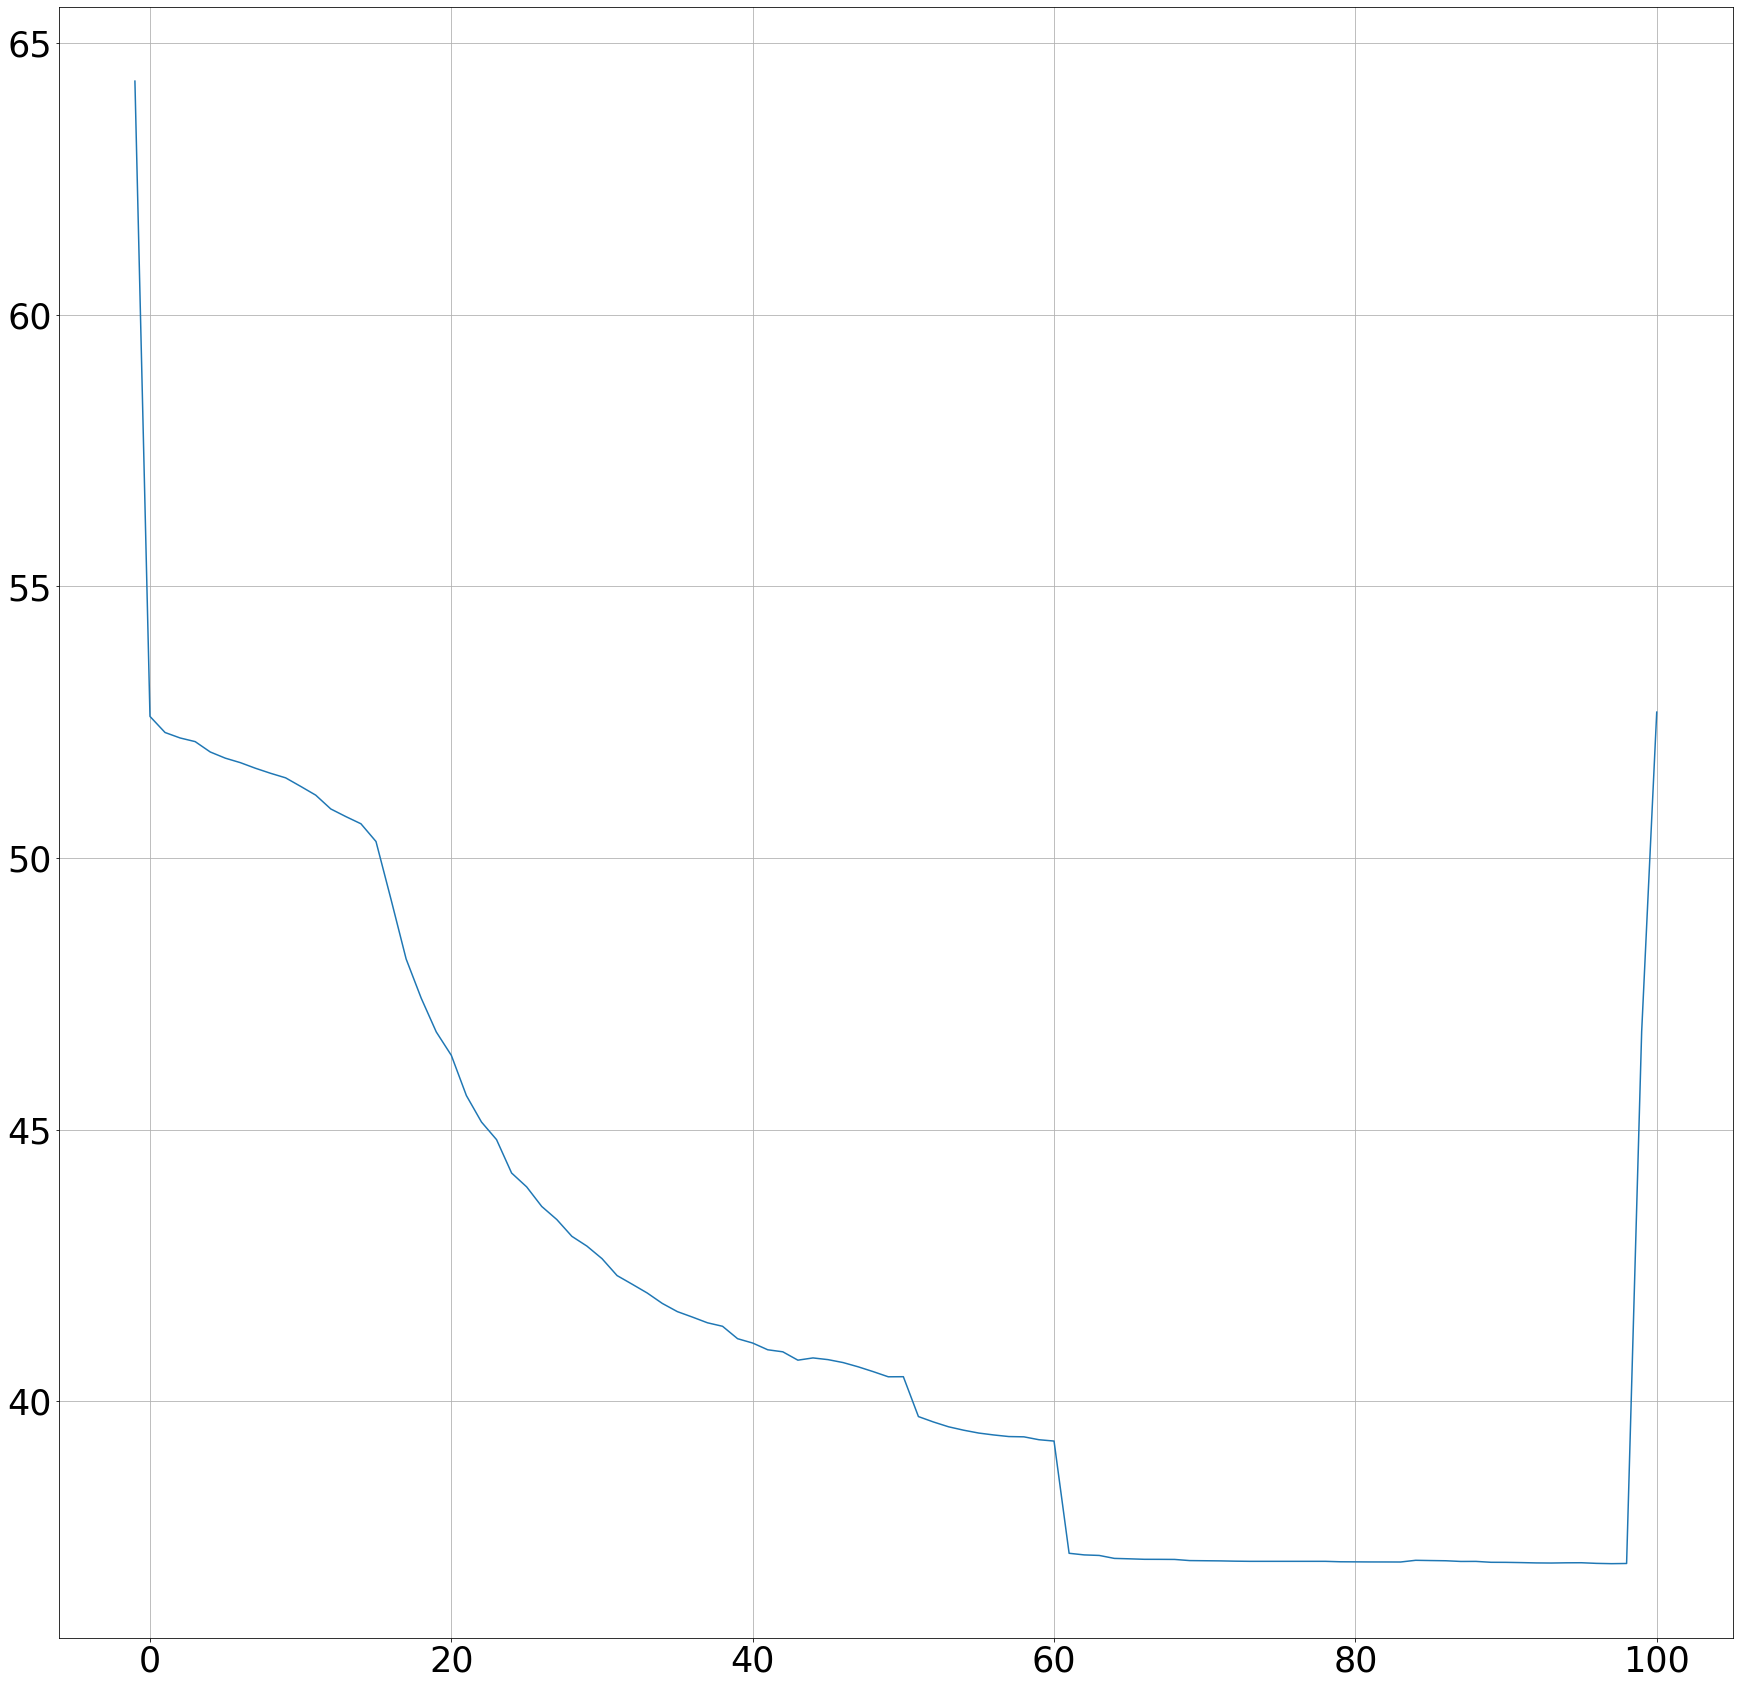

In [10]:
with open(MAIN_DATA_DIR+'/results/results.pickle', 'rb') as file:
    results = pickle.load(file)
ut.plot_mse(results)

And now is the most interesting part. I choose 4 embedding from training: embedding after first epoch, embedding after epoch 34, embedding after epoch 61 and embedding after epoch 93. I wrote a simple <a href="https://github.com/12jerek34jeremi/harry_potter/blob/main/hpcw/hpcw/utils.py">function</a> called count_distance that counts distance between two vectors. Distance between two vectors here is a sum of squares of differences of consecutive elements (a dot product of difference of vectors). It turned out that at first, with initial embedding, distance between nouns, verbs and adjectives is random. But after 93 epochs of training nouns are closer to other nouns than to verbs, verbs are closer to other verbs than to nouns and so on. Let's take a look:

In [23]:
embedding_initial = Embedding(corpus_size = len(my_corpus), embedding_size = 64, sizes=[256, 512, 1024], dropout_factor=0.18)
embedding0 = Embedding(corpus_size = len(my_corpus), embedding_size = 64, sizes=[256, 512, 1024], dropout_factor=0.18)
embedding0.load_embedding(MAIN_DATA_DIR + '/models/embedding_embedding0.pth')
embedding34 = Embedding(corpus_size = len(my_corpus), embedding_size = 64, sizes=[256, 512, 1024], dropout_factor=0.18)
embedding34.load_embedding(MAIN_DATA_DIR + '/models/embedding_embedding34.pth')
embedding61 = Embedding(corpus_size = len(my_corpus), embedding_size = 64, sizes=[256, 512, 1024], dropout_factor=0.18)
embedding61.load_embedding(MAIN_DATA_DIR + '/models/embedding_embedding61.pth')
embedding93 = Embedding(corpus_size = len(my_corpus), embedding_size = 64, sizes=[256, 512, 1024], dropout_factor=0.18)
embedding93.load_embedding(MAIN_DATA_DIR + '/models/embedding_embedding93.pth')
# Embedding class has option of loading and saving just the embedding part (without encoding).
# In above code I'm loading from file embedding state after epoch 0, 34, 61 and 93.

True

In [38]:
words = [('cat', 'dog'), ('cat', 'going'), ('hermione', 'water'), ('hermione', 'harry'),
         ('is', 'being'), ('is', 'was'), ('hagrid', 'dumbledore'), ('snake', 'snakes'),
         ('book', 'brilliant'), ('food', 'voldemort'), ('girl', 'boy'), ('girls', 'boys'),
        ('school', 'run')]

def check_distances(words: List[Tuple[str, str]], corpus: Corpus, embedding:Embedding):
  for word1, word2 in words:  
    dist = count_distance(word1, word2, corpus, embedding)
    print(f"    Distance between words '{word1}' and '{word2}' is {dist}")

In [40]:
print("For embedding_initial: ")
check_distances(words, my_corpus, embedding_initial)

For embedding_initial: 
    Distance between words 'cat' and 'dog' is 148.19186401367188
    Distance between words 'cat' and 'going' is 163.54542541503906
    Distance between words 'hermione' and 'water' is 128.1963653564453
    Distance between words 'hermione' and 'harry' is 122.0250473022461
    Distance between words 'is' and 'being' is 123.58283996582031
    Distance between words 'is' and 'was' is 157.10104370117188
    Distance between words 'hagrid' and 'dumbledore' is 144.09664916992188
    Distance between words 'snake' and 'snakes' is 142.73486328125
    Distance between words 'book' and 'brilliant' is 81.66374206542969
    Distance between words 'food' and 'voldemort' is 193.65582275390625
    Distance between words 'girl' and 'boy' is 80.12884521484375
    Distance between words 'girls' and 'boys' is 154.5997314453125
    Distance between words 'school' and 'run' is 113.10707092285156


In [41]:
print("For embedding0: ")
check_distances(words, my_corpus, embedding0)

For embedding0: 
    Distance between words 'cat' and 'dog' is 188.56365966796875
    Distance between words 'cat' and 'going' is 159.94679260253906
    Distance between words 'hermione' and 'water' is 124.99183654785156
    Distance between words 'hermione' and 'harry' is 87.04646301269531
    Distance between words 'is' and 'being' is 155.7615203857422
    Distance between words 'is' and 'was' is 111.06465148925781
    Distance between words 'hagrid' and 'dumbledore' is 114.62118530273438
    Distance between words 'snake' and 'snakes' is 136.7913055419922
    Distance between words 'book' and 'brilliant' is 134.72833251953125
    Distance between words 'food' and 'voldemort' is 121.21263885498047
    Distance between words 'girl' and 'boy' is 93.92500305175781
    Distance between words 'girls' and 'boys' is 139.14169311523438
    Distance between words 'school' and 'run' is 194.46804809570312


In [42]:
print("For embedding34: ")
check_distances(words, my_corpus, embedding34)

For embedding34: 
    Distance between words 'cat' and 'dog' is 180.727294921875
    Distance between words 'cat' and 'going' is 166.03314208984375
    Distance between words 'hermione' and 'water' is 103.7860336303711
    Distance between words 'hermione' and 'harry' is 37.58720779418945
    Distance between words 'is' and 'being' is 136.8767852783203
    Distance between words 'is' and 'was' is 71.04869079589844
    Distance between words 'hagrid' and 'dumbledore' is 58.269596099853516
    Distance between words 'snake' and 'snakes' is 131.8248291015625
    Distance between words 'book' and 'brilliant' is 129.81053161621094
    Distance between words 'food' and 'voldemort' is 115.80277252197266
    Distance between words 'girl' and 'boy' is 86.43671417236328
    Distance between words 'girls' and 'boys' is 136.47256469726562
    Distance between words 'school' and 'run' is 182.268310546875


In [43]:
print("For embedding61: ")
check_distances(words, my_corpus, embedding61)

For embedding61: 
    Distance between words 'cat' and 'dog' is 181.21087646484375
    Distance between words 'cat' and 'going' is 165.40618896484375
    Distance between words 'hermione' and 'water' is 104.39942932128906
    Distance between words 'hermione' and 'harry' is 35.331451416015625
    Distance between words 'is' and 'being' is 130.61114501953125
    Distance between words 'is' and 'was' is 64.57110595703125
    Distance between words 'hagrid' and 'dumbledore' is 46.249244689941406
    Distance between words 'snake' and 'snakes' is 130.7272491455078
    Distance between words 'book' and 'brilliant' is 133.10012817382812
    Distance between words 'food' and 'voldemort' is 110.18196105957031
    Distance between words 'girl' and 'boy' is 84.8621826171875
    Distance between words 'girls' and 'boys' is 127.60108184814453
    Distance between words 'school' and 'run' is 161.7185821533203


In [39]:
print("For embedding93: ")
check_distances(words, my_corpus, embedding93)

For embedding93: 
    Distance between words 'cat' and 'dog' is 180.9871063232422
    Distance between words 'cat' and 'going' is 165.05465698242188
    Distance between words 'hermione' and 'water' is 104.21701049804688
    Distance between words 'hermione' and 'harry' is 34.99916076660156
    Distance between words 'is' and 'being' is 130.53807067871094
    Distance between words 'is' and 'was' is 64.80520629882812
    Distance between words 'hagrid' and 'dumbledore' is 45.41228103637695
    Distance between words 'snake' and 'snakes' is 130.7606201171875
    Distance between words 'book' and 'brilliant' is 133.3353729248047
    Distance between words 'food' and 'voldemort' is 109.78778076171875
    Distance between words 'girl' and 'boy' is 84.70751953125
    Distance between words 'girls' and 'boys' is 127.25785827636719
    Distance between words 'school' and 'run' is 161.63497924804688


As you can see distance between words "hermione" and "harry" was at the beginning 122.0250473022461. Embedding learnt that they are both nouns of similar meanings (both are names). So after epoch 93 distance between those two words is 34.99916076660156.

   Initial distance between words "is" and "was" was 157.10104370117188. After 93 epoch it decreased to 64.80520629882812. Distance between words 'is' and 'being' is bigger, namely 130.53807067871094. But it is not 180. It kind of makes sense. You can say "Car is destroyed." or "Car was destroyed." and it sounds good. But sentence "Car being destroyed" without a context doesn't make sense.

   Also, initial distance between words 'school' and 'run' was 113.10707092285156. One is noun, second is verb, so distance between them should be bigger. And after 93 epochs it is, namely 161.63497924804688.
   
   Of course, some things does not make sense. For example, distance between words "cat" and "dog" is 180, they are far away each other. Both are names of animals, they should be close. The same situation is with words "snake" and "snakes", they should be close to each other. Results are good, but I think not good enough. My plan is now, before going further to train encoding, is to use transformers and Batch of Words model instead of LSTM's to train embedding. And then we can go further.
   
   That's it. I hope you enjoyed the reading. If you have some questions, or you want to hire a ML developer/researcher, you can write to me using this email address: jedrzej.chmiel.ml@gmail.com. 